In [1]:
import keras
import hrr as hrr
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# goal state:
bias = 1.0
reward = 1.0
gamma = 0.9
alpha = 0.01
lambd = 0.0
epsilon = 0.1
states = 20
episodes = 12000
non_reward = 0
hrr_size = 2048
non_goal_states = 0
actions = ['l', 'r']
colors = ['red', 'green', 'blue', 'purple']
gates = ['open', 'close']
sub_optimal_steps = []

In [3]:
memory = hrr.LTM(hrr_size, True)

In [4]:
def encode(s, a, g, signal, w_m):
    string = 'action_' + str(a) + "*" + \
             'gate_'   + str(g) + "*" + \
             'state_'  + str(s) + "*" + \
             'signal_' + str(signal) + "*" + \
             'w_m_' + str(w_m) 
    encoded = np.array([memory.encode(string)])
    return(encoded)

def q(state, signal, w_m):
    max_value = 0
    for a in actions:
        for g in gates:
            hrr = encode(state, a, g, signal, w_m)
            value = model.predict(hrr)[0,0] + bias
            if value > max_value:
                max_value = value
                max_hrr = hrr
                max_a = a
                gate = g
    return  max_value, max_hrr, max_a, gate

def random_q(state, signal, w_m):
    a = np.random.choice(actions)
    g = np.random.choice(gates)
    hrr = encode(state, a, g, signal, w_m)
    value = model.predict(hrr)[0,0] + bias
    return value, hrr, a, g

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.SGD(learning_rate=alpha))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2048      
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [6]:
for episode in range(episodes):
    if (episode+1) % 1000 == 0:
        print("on ", episode+1)
        
    if episode == int(episodes/4):
        epsilon = epsilon/2
        print('epsilon changed to:', epsilon)
        
    if episode == int(episodes/4 * 2):
        epsilon = epsilon/2
        print('epsilon changed to:', epsilon)
        
    if episode == int(episodes/2 * 3):
        epsilon = epsilon/2
        print('epsilon changed to:', epsilon)
        
#     if episode == int(episodes/4 * 3):
#         epsilon = 0
#         print('epsilon changed to:', epsilon)
        
    current_state = np.random.choice(states)
    current_signal = np.random.choice(colors)
    
    if current_signal == 'red':
            goal_state = 2
    elif current_signal == 'green':
        goal_state = 7
    elif current_signal == 'purple':
        goal_state = 12
    else:
        goal_state = 17
    
    if goal_state < current_state:
        optimal_steps_1 = abs(goal_state - current_state)
        optimal_steps_2 = states - current_state + goal_state
    else:
        optimal_steps_1 = abs(goal_state - current_state)
        optimal_steps_2 = states - goal_state + current_state
    
    if optimal_steps_1 < optimal_steps_2:
        optimal_steps = optimal_steps_1
    else:
        optimal_steps = optimal_steps_2
    
    current_w_m = ''
    
    for step in range(states):
        
        if current_state == goal_state:
            break
        
        if np.random.random() < epsilon:
            current_value, \
            current_hrr, \
            current_action, \
            gate_action = random_q(current_state, current_signal, current_w_m)
        else:
            current_value, \
            current_hrr, \
            current_action, \
            gate_action = q(current_state, current_signal, current_w_m)
        
        previous_state = current_state
        
        previous_value = current_value
        previous_hrr = current_hrr
        previous_action = current_action
        previous_gate_action = gate_action
        
        # --------------------------------------------------
        
        if gate_action == 'open':
            current_w_m = current_signal
        
        current_signal = ''
        
        if (current_action == "l"):
            current_state = (current_state-1)%states
        else:
            current_state = (current_state+1)%states
            
        if current_state == goal_state:
            target = reward
        else:
            current_value, _, _, _ = q(current_state, current_signal, current_w_m)
            target = non_goal_states + gamma * current_value

        model.fit(previous_hrr, [target-bias], verbose=0)
    
#     if step > 0:
#         steps = step + 1
#     else:
#         steps = 0
    sub_optimal_steps.append(abs(step-optimal_steps))
#     print('sub optimal steps taken =', abs(step-optimal_steps))

on  1000
on  2000
on  3000
epsilon changed to: 0.05
on  4000
on  5000
on  6000
epsilon changed to: 0.025
on  7000
on  8000
on  9000
on  10000
on  11000
on  12000


In [7]:
sub_optimal_average = []

for i in range(int(len(sub_optimal_steps)/100)):
    sub_optimal_average.append(sum(sub_optimal_steps[i*100:i*100+100])/len(sub_optimal_steps[i*100:i*100+100]))

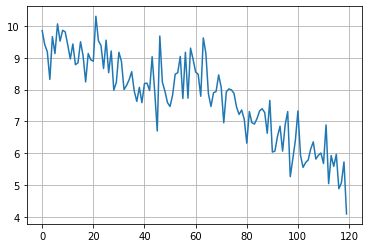

In [8]:
plt.plot(sub_optimal_average)
plt.grid(True)
plt.show()

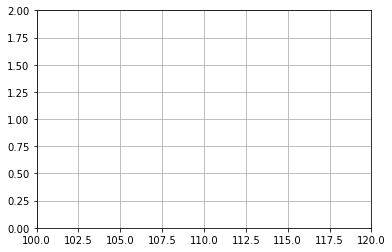

In [9]:
plt.plot(sub_optimal_average)
plt.grid(True)
plt.xlim(100,120)
plt.ylim(0, 2)
plt.show()

In [11]:
print('size of dictionary ', len(memory.store))

size of dictionary  3636


In [ ]:
# s, a, g, signal, w_m

In [ ]:
# red

In [ ]:
# all states, two actions l/r, gate closed, signal off, w_m red
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'close', '', 'red'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# all states, two actions l/r, gate open, signal off, w_m red
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', '', 'red'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# all states, two actions, gate closed, signal on red, no w_m
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'closed', 'red', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# all states, two actions, gate open, signal on red, no w_m
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', 'red', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# green

In [ ]:
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'close', '', 'green'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', '', 'green'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# all states, two actions, gate closed, signal on green, no w_m
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'closed', 'green', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# all states, two actions, gate open, signal on green, no w_m
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', 'green', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:

data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', '', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:

data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'closed', '', ''))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
### these should never occur

In [ ]:
# should never occur
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', 'red', 'red'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# should neve occur
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'closed', 'red', 'red'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# should never occur
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'open', 'green', 'green'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# should never occur
data = []
for a in actions:
#     for g in gates:
    data += [model.predict(encode(s, a, 'closed', 'green', 'green'))+bias for s in range(states)]
data = np.reshape(data, [2,states]).T
plt.plot(data)
plt.grid(True)
plt.legend(('left', 'right'))
plt.show()

In [ ]:
# data = []
# for a in actions:
#     for g in gates:
#         data += [model.predict(encode(s, a, g, 'red', ''))+bias for s in range(states)]
# data = np.reshape(data, [4,states]).T
# plt.plot(data)
# plt.show()